### Attention Layers and Transfer Learning For TinyImageNet Dataset 

Imports

In [2]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T
from torchvision import datasets
import matplotlib.pyplot as plt
import PIL

# Install Hugging Face Datasets

In [2]:
#Install the Hugging Face Datasets library if you haven't already:
!pip install -U datasets
#Restart after installation

Downloading the [Tiny ImageNet dataset](https://huggingface.co/datasets/zh-plus/tiny-imagenet)

In [12]:
from datasets import load_dataset

# Load the train split of the Tiny ImageNet dataset
# Load the train, and validation of the Tiny ImageNet dataset
## we can split the training dataset to be having training and validation datasets

train_dataset = load_dataset('zh-plus/tiny-imagenet', split='train')
print(f"Dstsdet size before split is: {len(train_dataset)}")
# split the training dataset into training and validation datasets
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset,[90000,10000])

test_dataset = load_dataset('zh-plus/tiny-imagenet', split='valid')

Dstsdet size before split is: 100000


## Check For Gray scale Images in the dataset

In [4]:
# Define a transform to convert images to tensors
transform = T.ToTensor()


# Function to check the size and number of channels of images in a dataset
def check_image_sizes_and_channels(dataset):
  counter_gray = 0
  for idx in range(len(dataset)): #idx in [0 ----89999]
        image = dataset[idx]['image']
        image_tensor = transform(image)
        channels, height, width = image_tensor.shape
        if channels != 3:
            counter_gray += 1
            #print(channels)
  print (f"Dataset contains {counter_gray} Gray scale images")

# Check image sizes and number of channels in the training dataset
check_image_sizes_and_channels(train_dataset)

Dataset contains 1644 Gray scale images


Filter the train,test, valid datasets from gray-scale images

In [13]:
# Define a transform to convert images to tensors

# Function to filter out grayscale images
def filter_rgb_images(dataset, transform):
    filtered_dataset = []
    for idx in range(len(dataset)):
        image = dataset[idx]['image']
        image_tensor = transform(image)
        channels, height, width = image_tensor.shape
        if channels == 3:
            filtered_dataset.append(dataset[idx])

    return filtered_dataset


transform = T.ToTensor()

# Filter the training, testing and validation datasets
RGB_train_dataset = filter_rgb_images(transform = transform, dataset = train_dataset)
RGB_valid_dataset = filter_rgb_images(transform = transform, dataset = valid_dataset)
RGB_test_dataset = filter_rgb_images(transform = transform, dataset = test_dataset)

# Display the number of images in the filtered datasets
print(f"Number of images in the filtered training dataset: {len(RGB_train_dataset)}")
print(f"Number of images in the filtered validation dataset: {len(RGB_valid_dataset)}")
print(f"Number of images in the filtered testing dataset: {len(RGB_test_dataset)}")

Number of images in the filtered training dataset: 88365
Number of images in the filtered validation dataset: 9814
Number of images in the filtered testing dataset: 9832


In [6]:
#Find shape of each image
print(transform(RGB_train_dataset[10]['image']).shape)


torch.Size([3, 64, 64])


In [8]:
#Show some images and labels (200 classes For tiny ImageNet)
#RGB_train_dataset[5]['image']
print(RGB_train_dataset[10]['label'])

181


# Integrate the dataset with PyTorch for use in a neural network



1.   Create Custom DataClass For that dataset
2.   Create DataLoaders using the DataClasses




---






In [14]:
#Create Custom Dataset object Since Tiny Image net doesn't have a Pytorch Dataset Object already created
#Unlike Fashion Mnist and Hand written Digits

class TinyImageNetDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        label = self.dataset[idx]['label']

        if self.transform:
            image = self.transform(image)

        return image, label

Adding all together

In [ ]:
#Data Augmentation is done for the training datset and not for validation or testing, Correct?

import torchvision.transforms as T
train_transform = T.Compose([T.Resize(68),
                             T.CenterCrop(64),
                             T.RandomAffine(translate =(0.1,0.1), degrees=0,  interpolation = T.InterpolationMode.BILINEAR ),
                             T.RandomHorizontalFlip(p=0.2),
                             T.ToTensor(),
                             T.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
                               ])

valid_transform = T.Compose ([T.Resize(68),
    T.CenterCrop(64),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])



In [13]:
#ToDo: Initialize the three data classes and Three dataloaders
train_dataClass = TinyImageNetDataset(RGB_train_dataset, transform = train_transform)
test_dataClass = TinyImageNetDataset(RGB_test_dataset, transform   = valid_transform)
valid_dataClass = TinyImageNetDataset(RGB_valid_dataset, transform = valid_transform)

#Create DataLoader For Each Dataset
TrainLoader = DataLoader(train_dataClass, batch_size=32, shuffle=True)
TestLoader  = DataLoader(test_dataClass, batch_size=32, shuffle=True)
ValidLoader = DataLoader(valid_dataClass, batch_size=32, shuffle=True)



### Visualize dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9295317..2.0996952].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8044444..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.68244..2.0474076].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5528543].


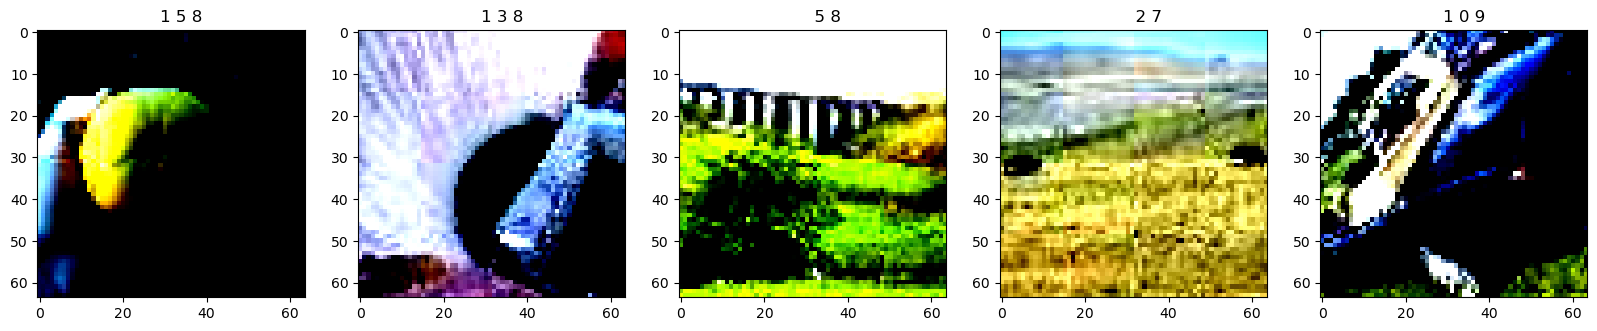

In [17]:
import matplotlib.pyplot as plt

def train_imshow(data_loader):
    dataiter = iter(data_loader)

    images_RGB, labels = next(dataiter) #dataiter.next() in older versions
    #print(images_RGB[0].shape)
    fig, axes = plt.subplots(figsize=(20, 8), ncols=5)
    for i in range(5):
        ax = axes[i]
        ax.imshow(images_RGB[i].permute(1, 2, 0))  #Permute Converts image size from 3x32x32 to 32x32x3
        #print(images_RGB[i].permute(1, 2, 0).shape)
        ax.title.set_text(' '.join('%5s' % data_loader.dataset.dataset[i]['label'])) #name the image of class value
    plt.show()
    
train_imshow(ValidLoader)

# Batch Normalization in CNN Architecture

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MyCNN(nn.Module):
    def __init__(self):
        # We optimize dropout rate in a convolutional neural network.
        super(MyCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 3, out_channels=16, kernel_size=3, stride=1, padding= 1)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1)
        #ToDo: Create a seconed Batch normalization layer called self.bn2
        self.bn2 = nn.BatchNorm2d(32)

        self.drop=nn.Dropout2d(p=0.2)

        ## ToDo: Create a MaxPool Layer of size (2,2) name it self.pool
        self.pool = nn.MaxPool2d(kernel_size = 2)

        self.fc1 = nn.Linear(32*16*16, 4096)  #2^12 = 4096
        self.bn3 = nn.BatchNorm1d(4096)   ###### Notice BatchNorm1d
        self.fc2 = nn.Linear(4096, 1024)  #1024 = 2^10
        self.bn4 = nn.BatchNorm1d(1024)   ###### Notice BatchNorm1d
        self.fc3 = nn.Linear(1024, 200)   # 200 classes


    def forward(self, x):

        x = self.pool(self.bn1(F.relu(self.conv1(x))))  #  3 x 64 x 64 ->  16 x 64 x 64 ->  16 x 32 x 32
        x = self.pool(self.bn2(F.relu(self.conv2(x))))  # 16 x 32 x 32   -->  32 x 32 x 32 ->  32 x 16 x 16
        x = self.drop(x)

        x = x.view(x.size(0),-1)             #32 x 16 x 16 -->8192

        x = self.bn3(F.relu(self.fc1(x)))    #8192 ->4096
        x = self.bn4(F.relu(self.fc2(x)))    #4096 ->1024
        x = self.fc3(x)                      #1024--> 200 #No Softmax or Logsoftmax activation layer added

        return x

# Do not change the name of yo'ur model or later cells may fail!
model = MyCNN()
model.to(device)

MyCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout2d(p=0.2, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=4096, bias=True)
  (bn3): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=4096, out_features=1024, bias=True)
  (bn4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=1024, out_features=200, bias=True)
)

### Specify Optimizer and Losse

In [19]:
#Use adam Optimizer (LR=0.002) and Cross Entropy as a loss function
optimizer = optim.Adam(model.parameters(), lr=0.002)
criterion =  nn.CrossEntropyLoss()

In [20]:
# Saving the model with the highest Validation accuracy
# Tracing Losses and accuracies and saving them in a dictionary called "history"

history={'train_loss':[],'valid_loss':[],'train_acc':[],'valid_acc':[]}
num_epochs=10
Validation_loss=float("inf")

for epoch in range(num_epochs):
    train_loss,train_correct=0.0,0

    model.train()
    for images, labels in TrainLoader:

        images,labels = images.to(device),labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()     #Correctly classified Images

    valid_loss, val_correct = 0.0, 0

    model.eval()
    with torch.no_grad():
      for images, labels in ValidLoader:

          images,labels = images.to(device),labels.to(device)
          output = model(images)
          loss=criterion(output,labels)
          valid_loss+=loss.item()*images.size(0)
          scores, predictions = torch.max(output.data,1)
          val_correct += (predictions == labels).sum().item()

    train_loss = train_loss / len(TrainLoader.sampler)
    train_acc = train_correct / len(TrainLoader.sampler)*100
    valid_loss = valid_loss / len(ValidLoader.sampler)
    valid_acc = val_correct / len(ValidLoader.sampler) * 100

    print("Epoch:{}/{} \t AVERAGE TL:{:.4f} AVERAGE VL:{:.4f} \t AVERAGE TA:{:.2f} %  AVERAGE VA:{:.2f} %".format(epoch + 1, num_epochs,
                                                                                         train_loss,
                                                                                         valid_loss,
                                                                                         train_acc,
                                                                                        valid_acc))
    #Check for best validation loss and use corresponding model
    if valid_loss< Validation_loss:
        Validation_loss=valid_loss
        best_model_state = model.state_dict()

    history['train_loss'].append(train_loss)
    history['valid_loss'].append(valid_loss)
    history['train_acc'].append(train_acc)
    history['valid_acc'].append(valid_acc)

torch.save(best_model_state, 'Best_model.pth')

Epoch:1/10 	 AVERAGE TL:4.5838 AVERAGE VL:3.9723 	 AVERAGE TA:8.41 %  AVERAGE VA:14.49 %
Epoch:2/10 	 AVERAGE TL:3.9175 AVERAGE VL:3.6190 	 AVERAGE TA:15.15 %  AVERAGE VA:19.44 %
Epoch:3/10 	 AVERAGE TL:3.7102 AVERAGE VL:3.5015 	 AVERAGE TA:18.27 %  AVERAGE VA:21.79 %
Epoch:4/10 	 AVERAGE TL:3.6172 AVERAGE VL:3.4320 	 AVERAGE TA:19.90 %  AVERAGE VA:23.28 %
Epoch:5/10 	 AVERAGE TL:3.4958 AVERAGE VL:3.4066 	 AVERAGE TA:21.69 %  AVERAGE VA:24.61 %
Epoch:6/10 	 AVERAGE TL:3.4023 AVERAGE VL:3.3175 	 AVERAGE TA:23.37 %  AVERAGE VA:25.66 %
Epoch:7/10 	 AVERAGE TL:3.3263 AVERAGE VL:3.2905 	 AVERAGE TA:24.85 %  AVERAGE VA:26.69 %
Epoch:8/10 	 AVERAGE TL:3.2802 AVERAGE VL:3.3169 	 AVERAGE TA:25.48 %  AVERAGE VA:26.82 %
Epoch:9/10 	 AVERAGE TL:3.2368 AVERAGE VL:3.6299 	 AVERAGE TA:26.27 %  AVERAGE VA:22.25 %
Epoch:10/10 	 AVERAGE TL:3.1560 AVERAGE VL:3.2150 	 AVERAGE TA:27.49 %  AVERAGE VA:28.37 %


### Complexity Graph

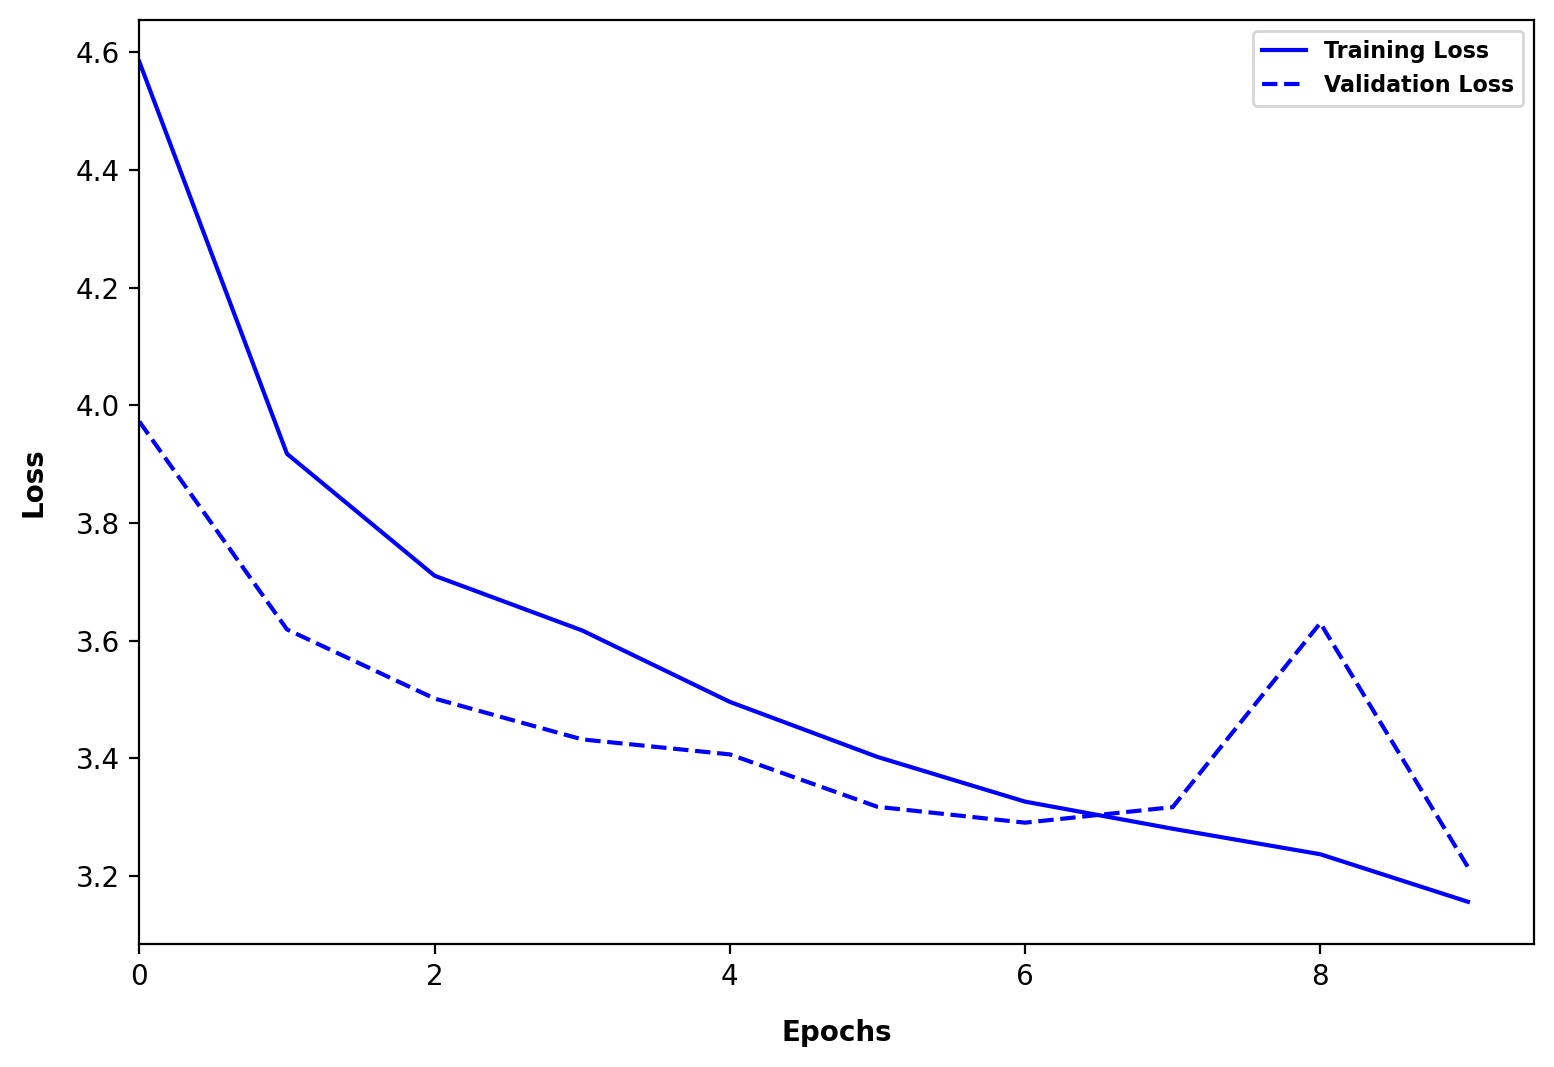

In [21]:

epochs=10
fig=plt.figure(figsize=(9,6),dpi=200)
x=[epoch for epoch in range(epochs)]
plt.plot(x,history['train_loss'],'b',label='Training Loss')
plt.plot(x,history['valid_loss'],'b',linestyle='dashed',label='Validation Loss')

plt.xlabel("Epochs",fontweight='bold',labelpad=10)
plt.ylabel("Loss",fontweight='bold',labelpad=10)
plt.xlim(xmin = 0)

plt.legend(prop={'size': 8,'weight':'bold'},loc="best")

plt.savefig(r'Losses.png',bbox_inches="tight")
plt.show()

### ✍️ToDo: Plot Accuracies


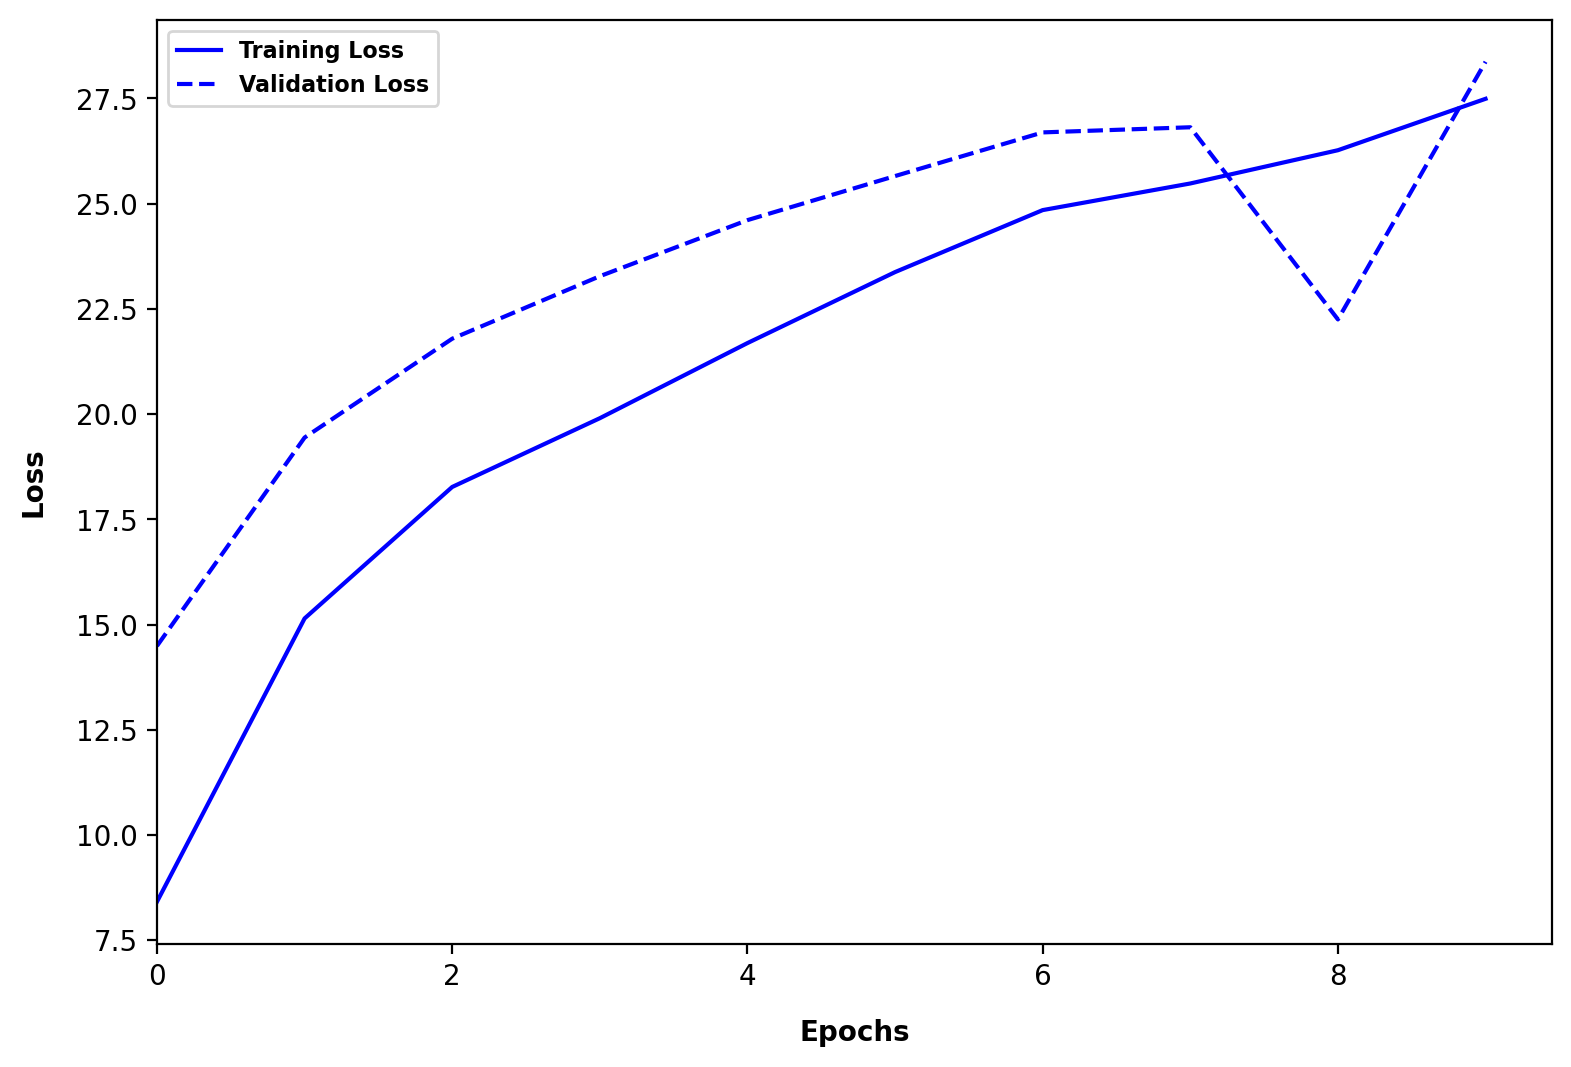

In [22]:
epochs=10
fig=plt.figure(figsize=(9,6),dpi=200)
x=[epoch for epoch in range(epochs)]
plt.plot(x,history['train_acc'],'b',label='Training Loss')
plt.plot(x,history['valid_acc'],'b',linestyle='dashed',label='Validation Loss')

plt.xlabel("Epochs",fontweight='bold',labelpad=10)
plt.ylabel("Loss",fontweight='bold',labelpad=10)
plt.xlim(xmin = 0)

plt.legend(prop={'size': 8,'weight':'bold'},loc="best")

plt.savefig(r'Losses.png',bbox_inches="tight")
plt.show()

### ✍️ToDo: Testing your model

In [24]:
model.load_state_dict(torch.load('Best_model.pth', map_location=device))

test_loss =0 
test_correct =0

model.eval()
with torch.no_grad():
    for images,labels in TestLoader:
        images,labels = images.to(device),labels.to(device)
        output = model(images)
        loss=criterion(output,labels)
        test_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(output.data,1)
        test_correct += (predictions == labels).sum().item()
          
    test_loss = test_loss / len(TestLoader.sampler)
    test_acc = test_correct / len(TestLoader.sampler)*100
    
    
print(f"Accuracy of the network on the test images: {test_acc} %")
print(f"Loss of the network on the test images: {test_loss}")    


Accuracy of the network on the test images: 28.81407648494711 %
Loss of the network on the test images: 3.186402255291857


### Add SE Block

In [25]:
class SEBlock(nn.Module):
    def __init__(self,in_channels):
        super(SEBlock, self).__init__()
        self.in_channels = in_channels
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1) #Averaging the pixels in one channel to give one final output
        self.fc1 = nn.Linear(self.in_channels , 8)  #n.channels
        self.fc2 = nn.Linear(8 , self.in_channels)  #n.channels

    def forward(self,x):
        se_tensor = self.global_avg_pool(x)                              # (Batches, Channels)
        se_tensor = se_tensor.view(se_tensor.size(0), -1)                #Put in 1D array
        se_tensor = F.relu(self.fc1(se_tensor))                          #(Batches, Channels)
        se_tensor = torch.sigmoid(self.fc2(se_tensor))
        # Reshape to (batch_size, channels, 1, 1) to multiply by input
        se_tensor = se_tensor.view(se_tensor.size(0), se_tensor.size(1), 1, 1)
        # Multiply the original feature maps by the SE tensor
        x = x * se_tensor
        return x

### Create CNN Model architecture

In [26]:
class MyCNN(nn.Module):
    def __init__(self):
        # We optimize dropout rate in a convolutional neural network.
        super(MyCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 3, out_channels=16, kernel_size=3, stride=1, padding= 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.se_block1 = SEBlock(in_channels=16)


        self.conv2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.se_block2 = SEBlock(in_channels=32)

        self.drop=nn.Dropout2d(p=0.2)

        self.pool = nn.MaxPool2d(kernel_size = 2)

        self.fc1 = nn.Linear(32*16*16, 4096) #2^12 = 4096
        self.bn3 = nn.BatchNorm1d(4096)   ###### Notice BatchNorm1d
        self.fc2 = nn.Linear(4096, 1024) #1024 = 2^10
        self.bn4 = nn.BatchNorm1d(1024)   ###### Notice BatchNorm1d
        self.fc3 = nn.Linear(1024, 200)   # 200 classes

    def forward(self, x):

        x = self.bn1(F.relu(self.conv1(x)))
        x = self.se_block1(x)
        x = self.pool(x)

        x = self.bn2(F.relu(self.conv2(x)))
        x = self.se_block2(x)
        x = self.pool(x)

        x = self.drop(x)

        x = x.view(x.size(0),-1)                    #32 x 16 x 16 -->8192

        x = self.bn3(F.relu(self.fc1(x)))           #8192 ->4096
        x = self.bn4(F.relu(self.fc2(x)))           #4096 ->1024
        x = self.fc3(x)                             #1024--> 200 #No Softmax or Logsoftmax activation layer added

        return x

# Do not change the name of your model or later cells may fail!
model = MyCNN()
model.to(device)

MyCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (se_block1): SEBlock(
    (global_avg_pool): AdaptiveAvgPool2d(output_size=1)
    (fc1): Linear(in_features=16, out_features=8, bias=True)
    (fc2): Linear(in_features=8, out_features=16, bias=True)
  )
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (se_block2): SEBlock(
    (global_avg_pool): AdaptiveAvgPool2d(output_size=1)
    (fc1): Linear(in_features=32, out_features=8, bias=True)
    (fc2): Linear(in_features=8, out_features=32, bias=True)
  )
  (drop): Dropout2d(p=0.2, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=4096, bias=True)
  (bn3): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=

### Specify Optimizer and Losse

In [27]:
#Use adam Optimizer (LR=0.002) and Cross Entropy as a loss function
optimizer = optim.Adam(model.parameters(), lr=0.002)
criterion =  nn.CrossEntropyLoss()

In [28]:
# Saving the model with the highest Validation accuracy
# Tracing Losses and accuracies and saving them in a dictionary called "history"

history={'train_loss':[],'valid_loss':[],'train_acc':[],'valid_acc':[]}
num_epochs=10
Validation_loss=float("inf")

for epoch in range(num_epochs):
    train_loss,train_correct=0.0,0

    model.train()
    for images, labels in TrainLoader:

        images,labels = images.to(device),labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()     #Correctly classified Images

    valid_loss, val_correct = 0.0, 0

    model.eval()
    with torch.no_grad():
        for images, labels in ValidLoader:

            images,labels = images.to(device),labels.to(device)
            output = model(images)
            loss=criterion(output,labels)
            valid_loss+=loss.item()*images.size(0)
            scores, predictions = torch.max(output.data,1)
            val_correct += (predictions == labels).sum().item()

    train_loss = train_loss / len(TrainLoader.sampler)
    train_acc = train_correct / len(TrainLoader.sampler)*100
    valid_loss = valid_loss / len(ValidLoader.sampler)
    valid_acc = val_correct / len(ValidLoader.sampler) * 100

    print("Epoch:{}/{} \t AVERAGE TL:{:.4f} AVERAGE VL:{:.4f} \t AVERAGE TA:{:.2f} %  AVERAGE VA:{:.2f} %".format(epoch + 1, num_epochs,
                                                                                         train_loss,
                                                                                         valid_loss,
                                                                                         train_acc,
                                                                                        valid_acc))
    #Check for best validation loss and use corresponding model
    if valid_loss< Validation_loss:
        Validation_loss=valid_loss
        best_model_state = model.state_dict()

    history['train_loss'].append(train_loss)
    history['valid_loss'].append(valid_loss)
    history['train_acc'].append(train_acc)
    history['valid_acc'].append(valid_acc)

torch.save(best_model_state, 'Best_model.pth')

Epoch:1/10 	 AVERAGE TL:4.5666 AVERAGE VL:4.1074 	 AVERAGE TA:8.58 %  AVERAGE VA:13.28 %
Epoch:2/10 	 AVERAGE TL:3.8830 AVERAGE VL:3.5946 	 AVERAGE TA:15.56 %  AVERAGE VA:19.87 %
Epoch:3/10 	 AVERAGE TL:3.6703 AVERAGE VL:3.5483 	 AVERAGE TA:18.88 %  AVERAGE VA:21.40 %
Epoch:4/10 	 AVERAGE TL:3.5494 AVERAGE VL:3.4706 	 AVERAGE TA:21.10 %  AVERAGE VA:22.97 %
Epoch:5/10 	 AVERAGE TL:3.4640 AVERAGE VL:3.3406 	 AVERAGE TA:22.50 %  AVERAGE VA:25.51 %
Epoch:6/10 	 AVERAGE TL:3.3658 AVERAGE VL:3.5192 	 AVERAGE TA:23.98 %  AVERAGE VA:26.02 %
Epoch:7/10 	 AVERAGE TL:3.3244 AVERAGE VL:3.3459 	 AVERAGE TA:24.99 %  AVERAGE VA:26.60 %
Epoch:8/10 	 AVERAGE TL:3.2590 AVERAGE VL:3.7701 	 AVERAGE TA:25.65 %  AVERAGE VA:23.66 %
Epoch:9/10 	 AVERAGE TL:3.1849 AVERAGE VL:3.2721 	 AVERAGE TA:27.07 %  AVERAGE VA:27.72 %
Epoch:10/10 	 AVERAGE TL:3.1859 AVERAGE VL:3.5033 	 AVERAGE TA:27.12 %  AVERAGE VA:27.67 %


### ✍️ToDo: Test model after adding the SE block

In [29]:
model.load_state_dict(torch.load('Best_model.pth', map_location=device))

test_loss =0 
test_correct =0

model.eval()
with torch.no_grad():
    for images,labels in TestLoader:
        images,labels = images.to(device),labels.to(device)
        output = model(images)
        loss=criterion(output,labels)
        test_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(output.data,1)
        test_correct += (predictions == labels).sum().item()
          
    test_loss = test_loss / len(TestLoader.sampler)
    test_acc = test_correct / len(TestLoader.sampler)*100
    
    
print(f"Accuracy of the network on the test images: {test_acc} %")
print(f"Loss of the network on the test images: {test_loss}")    

Accuracy of the network on the test images: 27.898698128559808 %
Loss of the network on the test images: 3.5089456280428184


## Transfer Learning

We will use ResNet 18 that was trained previously. We can see the model architecture on [ Netron](https://netron.app/). The dataset it was trained on was of size 224 x 224


In [3]:
import torchvision.models
model = torchvision.models.resnet18()


In [4]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
print(model.fc.out_features)
print(model.fc.in_features)

1000
512


In [15]:
!pip install torchsummary

In [5]:
from torchsummary import summary

# Must move model to device first
model.to("cuda" if torch.cuda.is_available() else "cpu")

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [6]:
#ToDo: Change the number of classes to be identical to the ones you have in your dataset
num_classes= 200
model.fc = nn.Linear(model.fc.in_features, num_classes)

Freezing the model parameters but not the final layer.

In [7]:
#Parameter freezing
for param in model.parameters():
    param.requires_grad = False
#Don't freeze FC layer parameters:
for param in model.fc.parameters():
    param.requires_grad = True

Resnet 18 was trained on 224 x 224 images

In [9]:
#Use adam Optimizer (LR=0.002) and Cross Entropy as a loss function
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.002)
criterion =  nn.CrossEntropyLoss()

In [10]:
# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

cuda


In [15]:
#Data Augmentation is done for the training datset and not for validation or testing, Correct?

import torchvision.transforms as T
train_transform = T.Compose([T.Resize(224),
                             T.CenterCrop(224),
                             T.ToTensor(),
                             T.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
                               ])

valid_transform = T.Compose ([T.Resize(224),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

#ToDo: Initialize the three data classes and Three dataloaders
train_dataClass = TinyImageNetDataset(RGB_train_dataset, transform = train_transform)
test_dataClass = TinyImageNetDataset(RGB_test_dataset, transform   = valid_transform)
valid_dataClass = TinyImageNetDataset(RGB_valid_dataset, transform = valid_transform)

#Create DataLoader For Each Dataset
TrainLoader = DataLoader(train_dataClass, batch_size=32, shuffle=True)
TestLoader  = DataLoader(test_dataClass, batch_size=32, shuffle=True)
ValidLoader = DataLoader(valid_dataClass, batch_size=32, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9637812..2.5702832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7521569..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].


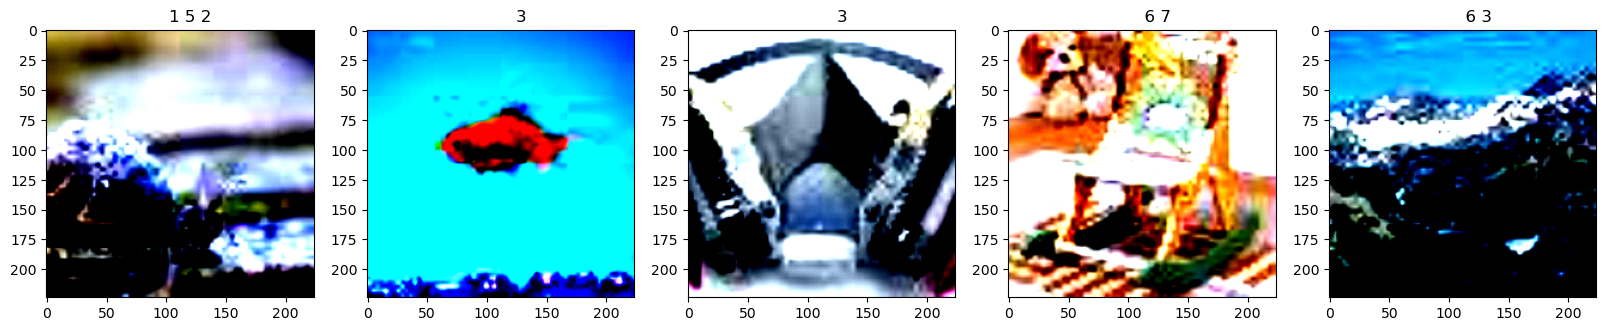

In [16]:
import matplotlib.pyplot as plt

def train_imshow(data_loader):
    dataiter = iter(data_loader)

    images_RGB, labels = next(dataiter) #dataiter.next() in older versions
    #print(images_RGB[0].shape)
    fig, axes = plt.subplots(figsize=(20, 8), ncols=5)
    for i in range(5):
        ax = axes[i]
        ax.imshow(images_RGB[i].permute(1, 2, 0))  #Permute Converts image size from 3x32x32 to 32x32x3
        #print(images_RGB[i].permute(1, 2, 0).shape)
        ax.title.set_text(' '.join('%5s' % data_loader.dataset.dataset[i]['label'])) #name the image of class value
    plt.show()
    
train_imshow(ValidLoader)

In [40]:
# Saving the model with the highest Validation accuracy
# Tracing Losses and accuracies and saving them in a dictionary called "history"

history={'train_loss':[],'valid_loss':[],'train_acc':[],'valid_acc':[]}
num_epochs=10
Validation_loss=float("inf")

for epoch in range(num_epochs):
    train_loss,train_correct=0.0,0

    model.train()
    for images, labels in TrainLoader:

        images,labels = images.to(device),labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()     #Correctly classified Images

    valid_loss, val_correct = 0.0, 0

    model.eval()
    with torch.no_grad():
        for images, labels in ValidLoader:

            images,labels = images.to(device),labels.to(device)
            output = model(images)
            loss=criterion(output,labels)
            valid_loss+=loss.item()*images.size(0)
            scores, predictions = torch.max(output.data,1)
            val_correct += (predictions == labels).sum().item()

    train_loss = train_loss / len(TrainLoader.sampler)
    train_acc = train_correct / len(TrainLoader.sampler)*100
    valid_loss = valid_loss / len(ValidLoader.sampler)
    valid_acc = val_correct / len(ValidLoader.sampler) * 100

    print("Epoch:{}/{} \t AVERAGE TL:{:.4f} AVERAGE VL:{:.4f} \t AVERAGE TA:{:.2f} %  AVERAGE VA:{:.2f} %".format(epoch + 1, num_epochs,
                                                                                         train_loss,
                                                                                         valid_loss,
                                                                                         train_acc,
                                                                                        valid_acc))
    #Check for best validation loss and use corresponding model
    if valid_loss< Validation_loss:
        Validation_loss=valid_loss
        best_model_state = model.state_dict()

    history['train_loss'].append(train_loss)
    history['valid_loss'].append(valid_loss)
    history['train_acc'].append(train_acc)
    history['valid_acc'].append(valid_acc)

torch.save(best_model_state, 'Best_model.pth')

Epoch:1/10 	 AVERAGE TL:5.3799 AVERAGE VL:5.3539 	 AVERAGE TA:2.73 %  AVERAGE VA:4.67 %
Epoch:2/10 	 AVERAGE TL:5.1193 AVERAGE VL:5.2174 	 AVERAGE TA:4.50 %  AVERAGE VA:4.92 %
Epoch:3/10 	 AVERAGE TL:4.9999 AVERAGE VL:5.2117 	 AVERAGE TA:5.54 %  AVERAGE VA:5.24 %
Epoch:4/10 	 AVERAGE TL:4.9220 AVERAGE VL:5.3333 	 AVERAGE TA:6.36 %  AVERAGE VA:5.35 %
Epoch:5/10 	 AVERAGE TL:4.8578 AVERAGE VL:5.1696 	 AVERAGE TA:6.91 %  AVERAGE VA:5.82 %
Epoch:6/10 	 AVERAGE TL:4.8176 AVERAGE VL:5.0984 	 AVERAGE TA:7.43 %  AVERAGE VA:6.08 %
Epoch:7/10 	 AVERAGE TL:4.7868 AVERAGE VL:5.1120 	 AVERAGE TA:7.68 %  AVERAGE VA:6.77 %
Epoch:8/10 	 AVERAGE TL:4.7494 AVERAGE VL:5.1771 	 AVERAGE TA:8.06 %  AVERAGE VA:6.48 %
Epoch:9/10 	 AVERAGE TL:4.7208 AVERAGE VL:5.0984 	 AVERAGE TA:8.29 %  AVERAGE VA:6.68 %
Epoch:10/10 	 AVERAGE TL:4.7010 AVERAGE VL:5.1762 	 AVERAGE TA:8.61 %  AVERAGE VA:6.80 %


### ✍️ToDo: Test model after fine tuning resNet18

In [17]:
model.load_state_dict(torch.load('Best_model.pth', map_location=device))

test_loss =0 
test_correct =0

model.eval()
with torch.no_grad():
    for images,labels in TestLoader:
        images,labels = images.to(device),labels.to(device)
        output = model(images)
        loss=criterion(output,labels)
        test_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(output.data,1)
        test_correct += (predictions == labels).sum().item()
          
    test_loss = test_loss / len(TestLoader.sampler)
    test_acc = test_correct / len(TestLoader.sampler)*100
    
    
print(f"Accuracy of the network on the test images: {test_acc} %")
print(f"Loss of the network on the test images: {test_loss}")    

Accuracy of the network on the test images: 6.661920260374288 %
Loss of the network on the test images: 5.1519172030604885


Accuracy is very bad. Guess why? 

Training only the last FC layer in this case isn't sufficient because the TinyImageNet is notsimilar to the original ImageNet dtaset especially in the size.

ImageNet size is 224 x 224. However, TinyImageNet size is 64 x 64. Since the dataset is big in size, 100k records, the adopted approach for transfer learning is training from scratch or training more layers not only the final FC layer.

### ✍️ToDo: Use resNet50 for transfer learning. 
It's your task to detect which layer to freeze and which ones to train.